<a href="https://colab.research.google.com/github/MarsLab-TUDelft/E-MaRSSim/blob/main/E_MaRSSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-MaRSSim
## Open-source educational MRI pulse sequence simulation tool

Authors: Ties Tensen, Maša Božić, Chiara Coletti, Sebastian Weingärtner (*TU Delft, Delft, The Netherlands*)

---




This notebook contains a simple MRI simulator which can be used to define a custom pulse sequence and simulate an image acquisition on a phantom.

During this tutorial we will simulate a spoiled GRE sequence on a cardiac phantom and we will observe the effects of blood flow. 

# Simulator 
This section contains the functions and classes needed to run  the simulation.

## Utilities
Some code cells to import necessary libraries, define auxiliary functions and the visualization function `plotMulti` which allows to display and compare multiple images in a single figure.

In [ ]:
# Imports
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.transform import resize, rescale
import scipy
import copy
from random import seed
from random import random
import random
import ipywidgets as widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numba as nb
from matplotlib.image import imread
from PIL import Image
from numba.experimental import jitclass
from numba import int64, deferred_type, optional, float64    # import the types
from numba.core.runtime import rtsys
from numba import jit #, njit
from collections import OrderedDict
from numba.typed import List
import multiprocessing
from matplotlib.image import imread
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import scipy.ndimage as ndimage

In [ ]:
# Rotation functions along cardinal axes
# Input:
#   alpha: rotation angle [radians] 
# Output:
#   R: rotation matrix
def rotX(alpha):
    R = np.array([[1, 0, 0], [0, np.cos(alpha), np.sin(alpha)], [0, -np.sin(alpha), np.cos(alpha)]])
    return R

def rotY(alpha):
    R = np.array([[np.cos(alpha), 0, -np.sin(alpha)], [0, 1, 0], [np.sin(alpha), 0, np.cos(alpha)]])
    return R

def rotZ(alpha):
    R = np.array([[np.cos(alpha), np.sin(alpha), 0], [-np.sin(alpha), np.cos(alpha), 0], [0, 0, 1]])
    return R


In [ ]:
# Visualization function to compare 3 images
# Input:
#   imgs [img1, img2, img3]:        Input images
#   [title1, title2, title3]:  Respective titles
def plotMulti(imgs, titles):

    # Number of subplots
    n = len(imgs)

    # Plot
    plt.figure(figsize = [15, 5])

    for i in range(len(imgs)):
        plt.subplot(1, n, i + 1)
        plt.imshow(imgs[i], cmap='gray')
        plt.axis('off')
        plt.title(titles[i])

    plt.plot()

## Phantom
Numerical cardiac phantom in short axis view

In [ ]:
image = "images/Brain_MRI.jpeg"
image_crop_max = "images/Brain_MRI_cropmax.jpeg"


def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))

image_RGB = Image.open(image)
image_RGB = crop_max_square(image_RGB)
image_RGB.save(image_crop_max, quality=95)
image_RGB = imread(image_crop_max)

r, g, b = image_RGB[:,:,0], image_RGB[:,:,1], image_RGB[:,:,2]

gamma_RGB = 1.04

r_const, g_const, b_const = 0.2126, 0.7152, 0.0722

image_grey = r_const*r**gamma_RGB + g_const*g**gamma_RGB + b_const*b**gamma_RGB
image_grey = image_grey[:, :, newaxis] #2D array to 3D array

#Smoothing of the image
image_grey = ndimage.gaussian_filter(image_grey, sigma=(5, 5, 0), order=0)

n_colors = 3 #number of colors

#load image
image_quant = np.array(image_grey, dtype=np.float64)/255
h, w, d = image_quant.shape
image_array = np.reshape(image_quant, (h*w, d))

#train kmeans based for a sample for n colors and predict
image_array_sample = shuffle(image_array, random_state = 0)[:1000]
kmeans = KMeans(n_clusters = n_colors).fit(image_array_sample)
labels = kmeans.predict(image_array)

#create the quantized image
image_out = np.zeros((h, w, d))
label_idx = 0
for i  in range(h):
    for j in range(w):
        image_out[i][j] = kmeans.cluster_centers_[labels[label_idx]]
        label_idx += 1
    

image_out = np.array(image_out*255, dtype=np.uint8)
val_PD = [image_out, image_out]
val_T1 = [image_out, image_out]
val_T2 = [image_out, image_out]

phantom_size = np.matrix(val_PD[0])

rescale_val = 0.03     #Value for rescaling the size of the phantoms
strn_B0 = 2000         #Strenght of the off resonance in the B0 field


#While loop for making the dimensions of the phantoms od
while True:
    number = rescale(phantom_size, rescale_val, anti_aliasing=False).shape[0]
    declared_number = int(number)
    if declared_number == 0:
        break

    left = declared_number % 2

    if left == 0:
        rescale_val += 0.001
    elif left > 0:
        print('New rescale value =', rescale_val)
        print('New dimension =', rescale(phantom_size, rescale_val, anti_aliasing=False).shape[0])
        break
        
# Set and rescale PD phantom         
for i in range(0,len(val_PD)):
    phantom_PD = np.matrix(val_PD[i])
    phantom_PD = rescale(phantom_PD, rescale_val, anti_aliasing=False)
    if i == 0:
        phantomPD = phantom_PD
    else:     
        phantomPD = np.dstack([phantomPD, phantom_PD])
        
# Set and rescale T1 phantom        
for i in range(0,len(val_T1)):
    phantom_T1 = np.matrix(val_T1[i])
    phantom_T1 = rescale(phantom_T1, rescale_val, anti_aliasing=False)
    phantom_T1 = ((phantom_T1 - np.min(phantom_T1))/np.max(phantom_T1))*2000
    if i == 0:
        phantomT1 = phantom_T1
    else:     
        phantomT1 = np.dstack([phantomT1, phantom_T1])        

# Set and rescale T2 phantom
for i in range(0,len(val_T2)):
    phantom_T2 = np.matrix(val_T2[i])
    phantom_T2 = rescale(phantom_T2, rescale_val, anti_aliasing=False)
    phantom_T2 = ((phantom_T2 - np.min(phantom_T2))/np.max(phantom_T2))*250
    if i == 0:
        phantomT2 = phantom_T2
    else:     
        phantomT2 = np.dstack([phantomT2, phantom_T2]) 
        
# Set and rescale B0 phantom
for i in range(0,len(val_T2)):
    size = np.matrix(val_PD[0]).shape[0]
    B0_ = np.tile(np.linspace(strn_B0, -strn_B0, size), (size, 1)).T
    B0_ = rescale(B0_, rescale_val, anti_aliasing=False)
    if i == 0:
        B0 = B0_
    else:     
        B0 = np.dstack([B0, B0_])  

New rescale value = 0.03
New dimension = 17


In [ ]:
# Read in phantom as a matrix
val = '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 3 3 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 3 3 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071'

PD_1 = '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 3 3 3 3 3 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071'
PD_2 = '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 0.600000023841858 1 1 1 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 2.5 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 2.5 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 2.5 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 2.5 2.5 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 1 1 1 1 1 1 1 1 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071'

T1_1 = '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 1450 1450 1450 1450 1450 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1550 1550 1450 1450 1450 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1550 1550 1550 1550 1450 1450 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1550 1550 1550 1550 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1550 1550 1550 1550 1450 1450 1450 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1550 1550 1550 1550 1450 1450 1450 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1550 1550 1550 1550 1550 1550 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1550 1550 1550 1550 1550 1550 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1550 1550 1550 1550 1550 1550 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1550 1550 1550 1550 1550 1550 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1550 1550 1550 1550 1550 1550 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1550 1550 1550 1550 1550 1550 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1550 1550 1550 1550 1550 1550 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1550 1550 1550 1550 1550 1550 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1550 1550 1550 1550 1450 1450 1450 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1550 1550 1550 1550 1450 1450 1450 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1550 1550 1550 1550 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1550 1550 1550 1550 1450 1450 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1550 1550 1450 1450 1450 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 1450 2000 2000 2000 400 400 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 400 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 400 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 400 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 400 400 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 400 400 400 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 400 400 400 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 400 400 400 400 400 2000 2000 2000 2000 2000 2000 2000 2000 400 400 400 400 400 400 400 400 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 400 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 400 400 400 400 400 400 400 400 400 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900'
T1_2 = '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 1350 1350 1350 1350 1350 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1450 1450 1350 1350 1350 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1450 1450 1450 1450 1350 1350 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1450 1450 1450 1450 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1450 1450 1450 1450 1350 1350 1350 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1450 1450 1450 1450 1350 1350 1350 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1450 1450 1450 1450 1450 1450 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1450 1450 1450 1450 1450 1450 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1450 1450 1450 1450 1450 1450 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1450 1450 1450 1450 1450 1450 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1450 1450 1450 1450 1450 1450 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1450 1450 1450 1450 1350 1350 1350 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1450 1450 1450 1450 1350 1350 1350 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1450 1450 1450 1450 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1450 1450 1450 1450 1350 1350 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1450 1450 1350 1350 1350 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 1350 2000 2000 2000 450 450 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 450 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 450 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 450 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 450 450 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 450 450 450 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 450 450 450 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 450 450 450 450 450 2000 2000 2000 2000 2000 2000 2000 2000 450 450 450 450 450 450 450 450 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 450 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 0 0 0 0 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 0 0 0 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 450 450 450 450 450 450 450 450 450 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900'

T2_1 = '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 45 45 45 45 45 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 45 45 45 45 45 45 45 45 45 45 45 45 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 45 45 45 45 45 45 45 45 45 45 45 45 45 250 250 250 100 100 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 100 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 100 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 100 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 100 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 100 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 100 100 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 100 100 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 100 100 100 100 100 100 250 250 250 250 250 250 250 250 250 250 250 250 250 250 100 100 100 100 100 100 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 100 100 100 100 100 250 250 250 250 250 250 250 250 100 100 100 100 100 100 100 100 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 100 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100 100 100 100 100 100 100 100 100 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15'
T2_2 = '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 55 55 55 55 55 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 55 55 55 55 55 55 55 55 55 55 55 55 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 55 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 55 55 55 55 55 55 55 55 55 55 55 55 55 250 250 250 150 150 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 150 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 150 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 150 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 150 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 150 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 150 150 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 150 150 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 150 150 150 150 150 150 250 250 250 250 250 250 250 250 250 250 250 250 250 250 150 150 150 150 150 150 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 150 150 150 150 150 250 250 250 250 250 250 250 250 150 150 150 150 150 150 150 150 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 150 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 0 0 0 0 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 0 0 0 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 150 150 150 150 150 150 150 150 150 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15'

val_PD = [PD_1, PD_2]
val_T1 = [T1_1, T1_2]
val_T2 = [T2_1, T2_2]

phantom_size = np.matrix(val_PD[0])

rescale_val = 0.4     #Value for rescaling the size of the phantoms
strn_B0 = 2000        #Strenght of the off resonance in the B0 field

#While loop for making the dimensions of the phantoms odd
while True:
    number = rescale(phantom_size, rescale_val, anti_aliasing=False).shape[0]
    declared_number = int(number)
    if declared_number == 0:
        break

    left = declared_number % 2

    if left == 0:
        rescale_val += 0.001
    elif left > 0:
        print('New rescale value =', rescale_val)
        print('New dimension =', rescale(phantom_size, rescale_val, anti_aliasing=False).shape[0])
        break
        
# Set and rescale PD phantom
for i in range(0,len(val_PD)):
    phantom_PD = np.matrix(val_PD[i])
    phantom_PD = rescale(phantom_PD, rescale_val, anti_aliasing=False)
    if i == 0:
        phantomPD = phantom_PD[:, :, newaxis]
    else:     
        phantomPD = np.dstack([phantomPD, phantom_PD])

# Set and rescale T1 phantom        
for i in range(0,len(val_T1)):
    phantom_T1 = np.matrix(val_T1[i])
    phantom_T1 = rescale(phantom_T1, rescale_val, anti_aliasing=False)
    phantom_T1 = ((phantom_T1 - np.min(phantom_T1))/np.max(phantom_T1))*2000
    if i == 0:
        phantomT1 = phantom_T1[:, :, newaxis]
    else:     
        phantomT1 = np.dstack([phantomT1, phantom_T1])        

# Set and rescale T2 phantom
for i in range(0,len(val_T2)):
    phantom_T2 = np.matrix(val_T2[i])
    phantom_T2 = rescale(phantom_T2, rescale_val, anti_aliasing=False)
    phantom_T2 = ((phantom_T2 - np.min(phantom_T2))/np.max(phantom_T2))*250
    if i == 0:
        phantomT2 = phantom_T2[:, :, newaxis]
    else:     
        phantomT2 = np.dstack([phantomT2, phantom_T2])
        
# Set and rescale B0 phantom
for i in range(0,len(val_T2)):
    size = np.matrix(val_PD[0]).shape[0]
    B0_ = np.tile(np.linspace(strn_B0, -strn_B0, size), (size, 1)).T
    B0_ = rescale(B0_, rescale_val, anti_aliasing=False)
    if i == 0:
        B0 = B0_[:, :, newaxis]
    else:     
        B0 = np.dstack([B0, B0_])   

New rescale value = 0.404
New dimension = 61



## Image & k-Space 
The `isoGrid` class implements the geometrical objects used as inputs/outputs for the pulse sequence simulations and their auxiliary functions. These include:
- `M0`: input 3D isochromat grid
- `velAccMap`: flow properties map for the isochromat grid
- `kSpace`: k space grid, computed during the sequence simulation




In [ ]:
# Class to hold the input image and ouput k-Space
class isoGrid:

    # Constructor: Initialize with phantom image
    # Input:
    #   phantom: Matrix initialization
    def __init__(self, phantomPD = np.zeros((128, 128, 2)), phantomT1 = np.zeros((128, 128, 2)), phantomT2 = np.zeros((128, 128, 2)), B0 = np.zeros((128, 128, 2))):
    
        self.getT1map(phantomT1)
    
        self.getT2map(phantomT2)
        
        self.getB0map(B0)
    
        # Write input data to isochromat grid array
        M0 = np.zeros((phantomPD.shape[0], phantomPD.shape[1], phantomPD.shape[2], 3))
        M0[:,:,:,2] = phantomPD
        self.M0 = np.array(M0)
        
        # Calculate velocity/acceleration maps for flow-simulations
        self.velAccMap()

        # Initialize empty k-space
        self.kSpace = np.zeros((self.M0.shape[0], self.M0.shape[1], self.M0.shape[2]), dtype=complex)
    
    def getT1map(self, phantomT1):
        self.T1map = phantomT1
        
    
    def getT2map(self, phantomT2):
        self.T2map = phantomT2
        
    def getB0map(self, B0):
        self.B0map = B0
  
    # Initialize flow velocity and acceleration maps
    def velAccMap(self):

        # Initialize empty arrays
        self.vGrid = np.zeros_like(self.M0)
        self.aGrid = np.zeros_like(self.M0)

        # Set velocity and acceleration vectors for blood and myocardium
        vBlood = np.array([0.4, 0.8, 0])   # [m/s]
        aBlood = np.array([0.02, 0.08, 0]) # [m/s^2]
        vMyo = np.array([0.1, 0.1, 0])     # [m/s]
        aMyo = np.array([0.005, 0.005, 0]) # [m/s^2]

        # Set v and a properties to blood and myocardium pixels
        I_Blood = 1 # phantom intensity in ventricles
        I_Myo = 0.800000011920929 # phantom intensity in myocardium
        for i in range(self.vGrid.shape[0]):
            for j in range(self.vGrid.shape[1]):
                for k in range(self.vGrid.shape[2]):
                    if self.M0[i, j, k, 2] == I_Blood:
                        self.vGrid[i,j,k,:] = vBlood
                        self.aGrid[i,j,k,:] = aBlood
                    elif self.M0[i, j, k, 2] == I_Myo:
                        self.vGrid[i,j,k,:] = vMyo
                        self.aGrid[i,j,k,:] = aMyo

    # Get center points in all dimensions
    # Input:
    #   ax: Image axis
    #          0: X-Axis, 1: Y-Axis, 2: Z-Axis
    def getCenter(self,ax):
        return np.floor((self.M0.shape[ax]-1)/2)


    # Get size in all dimensions
    # Input:
    #   ax: Image axis
    #          0: X-Axis, 1: Y-Axis, 2: Z-Axis
    def getSize(self,ax):
        return self.M0.shape[ax]


## Gradients
The `Gradient` class is used to define and compute the single gradient objects of the MRI sequence.


In [ ]:
# Gradient class for rectangular gradients
class Gradient:

    # Constructor
    # Input:
    #   seq:  Sequence Object
    #   strn: Gradient Amplitude        [T/m]
    #           (or step size if steps > 1)
    #   dur:  Gradient Duration         [s]
    #   t0:   Start Time within the TR  [s]
    #   ax:   Gradient axis
    #           0 : x - axis (readout)
    #           1 : y - axis (phase)
    #           2 : z - axis (slice)
    #   steps: Number of gradient steps
    def __init__(self, seq, strn=30, dur=0, t0=0, ax=0, steps=0):
        # Initialize Member Variables
        self.strn     = strn
        self.steps    = steps
        self.ax       = ax
        self.dur_dts  = (int)(np.round(dur/seq.dt))
        self.t0_dts   = (int)(np.round(t0/seq.dt))

        # Add gradient to gradient list of sequence
        seq.addGradient(self)


    # Output function: Generates the gradient trace associated with this gradient
    # Input:
    #   seq:  Pulse sequence 
    # Output:
    #   G:    Gradient Trace
    def getTrace(self, seq):
        #Initialize empty trace
        G = np.zeros((3, (int)(np.round(seq.TR/seq.dt)), seq.nKy))

        if self.steps == 0:
            #For 0 steps, assign the same strengths to each repetition (ky line)
            G[self.ax, self.t0_dts:(self.t0_dts+self.dur_dts), :] = self.strn
        else:
            #Otherwise use self.strn as step size between the gradients
            G[self.ax, self.t0_dts:(self.t0_dts+self.dur_dts), :] = [self.strn*(i-((self.steps-1)/2)) for i in range(self.steps)]
        return G


## RF Pulse
The `RFpulse` class is used to define and compute the single RF pulse objects of the MRI sequence.


In [ ]:
class RFpulse:

    # Constructor
    # Input:
    #   seq:  Sequence Object
    #   fa:   Flip angle                [degrees]
    #   tExc: Durationof RF pulse       [s]
    #   t0Exc: Starting time RF pulse   [s]
    def __init__(self, seq, fa, tExc=1e-3, t0Exc=0): #fa=90
        # Initialize Member Variables
        self.fa       = fa
        self.tExc     = tExc
        self.t0Exc    = t0Exc
        self.B1       = np.deg2rad(self.fa)/self.tExc; #[rad/s]
        self.delfreq  = 200 #Hz
        self.gamma    = 42.58e+6  #[Hz/T]

        # Add RF pulse to the sequence
        seq.addRFpulse(self)


    # Output function: Generates the RF pulse trace associated with this pulse
    # Input:
    #   seq:  Pulse sequence
    # Output:
    #   RF:   Radio frequency pulse trace
    def getTrace(self, seq):
        # Initialize empty trace
        RF = np.zeros((3, (int)(np.round((seq.TR/seq.dt)))))

        # Assign RF pulse strength 
        RF[0, (int)(self.t0Exc / seq.dt):(int)((self.t0Exc+ self.tExc) / seq.dt)] = self.B1

        return RF


## Sequence
The `Sequence` class is used to define, compute and simulate the complete MRI sequence. The workflow to run the simulation should be:

1. Initialize the sequence by defining an new instance of a sequence object

2. Define the RF pulse objects of this sequence

3. Define the gradient objects of this sequence

4. Calculate the sequence.

5. Plot the resulting pulse sequence diagram.

In [ ]:
class Sequence:

    # Constructor
    # Input:
    #   seq:  Sequence Object
    #   TR:   Repetition Time           [s]
    #   nKx:  Number of samples along X
    #   nKy:  Number of samples along Y (phase encoding lines)
    def __init__(self, TR, TE, t0ADC, nKx, nKy):
        #General parameters
        # Gyromagnetic Ratio
        self.gamma  = 42.58e+6  #[Hz/T]
        # Temporal simulation resolution
        self.dt     = 0.1e-03 #[s]
        # Voxel Size
        self.resolution = [1e-3, 1e-3, 10e-3] # [m]
        # Noise
        self.noise = np.random.normal(0, 0.5)
        #B0 main magnetic field
        self.B0 = 3 #[T]

        #Initialize Member Variables
        self.TR    = TR
        self.TE    = TE
        self.t0ADC = t0ADC
        self.nKx   = nKx
        self.nKy   = nKy

        #Set gradient and RFtraces to zero
        self.Beff_t = np.zeros((3, (int)(np.round(TR/self.dt))))
        self.G_t    = np.zeros((3, (int)(np.round(TR/self.dt)), self.nKy))
        self.ADC    = np.zeros((1, (int)(np.round(TR/self.dt))))

        #Initialize Empty Gradient and RF object list
        self.gradientList = []#empty_float64_list()
        self.rfList = []#empty_float64_list()

        #Define hardware limitations
        self.Gmax   = [70e-2] * 3 # [T/m]
        #origianal self.Gmax = [35e-3] *3
        
        #Internal variable to ensure the sequence is calculated prior to simulation
        self._isCalculated = False

    # Add RF pulse to sequence
    # Input:
    #   RFp:  RF pulse object
    def addRFpulse(self, rf):
        self.rfList.append(rf)
        self._isCalculated = False


    # Add Gradient to list
    # Input:
    #   gradient:  Gradient Object
    def addGradient(self, gradient):
        self.gradientList.append(gradient)
        self._isCalculated = False


    # Calculate the sequence and generate Gradient/RF Trace
    def calculateSequence(self):
        # Combine all Gradient objects in the sequence
        self.G_t    = np.zeros((3, (int)(np.round(self.TR/self.dt)), self.nKy))
        for g in self.gradientList:
            self.G_t += g.getTrace(self)

        # Combine all RF objects in the sequence
        self.Beff_t    = np.zeros((3, (int)(np.round(self.TR/self.dt))))
        for rf in self.rfList:
            self.Beff_t += rf.getTrace(self)

        # Compute ADC trace
        t0ADC_dts = (int)(np.round(self.t0ADC/self.dt))
        self.ADC[0, t0ADC_dts : t0ADC_dts + nKx] = 1

        # Check for hardware limitation violations
        if np.any( np.greater( np.max( np.max( np.abs(self.G_t), axis=2), axis=1 ), self.Gmax ) ):
            print (np.max( np.max( np.abs(self.G_t), axis=2), axis=1 ), self.Gmax)
            raise Exception("Gradient Limit exceeded")

        # Mark the Sequence as calculated
        self._isCalculated = True


    # Simulate the sequence
    # Input:
    #   isoGrid:  Grid Object containing the image
    # Output:
    #   isoGrid:  Grid Object with simulated k-Space
    def simSeq(self, isoGrid):
        # Check if the sequence has been calculated
        if not self._isCalculated:
            raise Exception("The sequence has to be calcuated before execution!")

        # Define Matrix to hold the magnetization vectors for each voxel as a function of time
        M_t = np.zeros(((int)(self.TR/self.dt)+1, isoGrid.M0.shape[0], isoGrid.M0.shape[1], isoGrid.M0.shape[2], isoGrid.M0.shape[3]))
        # Initialize the first time point with the input image
        M_t[0, :, :, :, :] = isoGrid.M0

        # Simulate the excitations
        isoGrid, M_t = self._simSeqExcAcq(isoGrid, M_t)
        
        return isoGrid, M_t
    
    def calc_r(self, isoGrid):
        r = np.zeros((isoGrid.getSize(0), isoGrid.getSize(1), isoGrid.getSize(2), 3))
        for i in range(isoGrid.getSize(0)):
            for j in range(isoGrid.getSize(1)):
                for k in range(isoGrid.getSize(2)):
                    r[i,j,k,0] = np.multiply( [i-isoGrid.getCenter(0)], self.resolution[0] )
                    r[i,j,k,1] = np.multiply( [j-isoGrid.getCenter(1)], self.resolution[1] )
                    r[i,j,k,2] = np.multiply( [k-isoGrid.getCenter(2)], self.resolution[2] )
                                             
        return r
    
    def A_mtrx(self, isoGrid, E1, E2, rot):
        A = np.zeros((isoGrid.getSize(0), isoGrid.getSize(1), isoGrid.getSize(2), 3, 3))
        for i in range(isoGrid.getSize(0)):
            for j in range(isoGrid.getSize(1)):
                for k in range(isoGrid.getSize(2)):
                    A[i,j,k,0,0] = E2[i,j,k]
                    A[i,j,k,1,1] = E2[i,j,k]
                    A[i,j,k,2,2] = E1[i,j,k]
                    A[i,j,k,:,:] = A[i,j,k,:,:] @ rot
        return A
    
    def B_mtrx(self, isoGrid, E1):
        B = np.zeros((isoGrid.getSize(0), isoGrid.getSize(1), isoGrid.getSize(2), 3))
        for i in range(isoGrid.getSize(0)):
            for j in range(isoGrid.getSize(1)):
                for k in range(isoGrid.getSize(2)):
                    B[i,j,k,2] = 1 - E1[i,j,k]   
        return B
    
    def rotGF_mtrx(self, isoGrid, theta):
        rotGF = np.zeros((isoGrid.getSize(0), isoGrid.getSize(1), isoGrid.getSize(2), 3, 3))
        for i in range(isoGrid.getSize(0)):
            for j in range(isoGrid.getSize(1)):
                for k in range(isoGrid.getSize(2)):
                    rotGF[i,j,k,:] = rotZ(theta[i,j,k])
        return rotGF

    # Simulate the effect of the Gradient objects
    # Input:
    #   isoGrid:  Grid Object containing the image
    #   M_t:      Matrix containig magnetization vectors over time
    # Output:
    #   isoGrid:  Grid Object containing the image
    #   M_t:      Matrix containig magnetization vectors over time after Gradient simulations
    def _simSeqExcAcq(self, isoGrid, M_t):
        print("Simulating excitation...\n")
        print("Simulating acquisition...\n")

        # Calculate time point of ADC in dime step units
        t0ADC_dts = (int)(np.round(self.t0ADC/self.dt))

        M_t0 = copy.deepcopy(M_t)

        # Loop over repetitions (ky lines)
        for ky in tqdm(range(nKy)):

            # Reset Magnetization vector to state after application of RF pulses
            # at the beginning of each TR
            if (ky > 0):
                M_t = copy.deepcopy(M_t0)
            
            #r = self.calc_r(isoGrid)
            
            # Loop over voxels in all spatial dimensions of image
            #for k in range(isoGrid.getSize(2)):
            T1 = isoGrid.T1map[:,:,:]#*50
            T2 = isoGrid.T2map[:,:,:]#*50
            B0 = isoGrid.B0map[:,:,:]

            #phi_precess = -self.B0*self.gamma*self.dt
            phi_precess = 0

            E1 = np.exp(-self.dt/T1)
            E2 = np.exp(-self.dt/T2)

            A = self.A_mtrx(isoGrid, E1, E2, rotZ(phi_precess))
            B = self.B_mtrx(isoGrid, E1)

            # Calculate location of the current voxel
            r = self.calc_r(isoGrid)[:,:,:,:]
            for t in range(1, (int)(np.round(self.TR/self.dt))+1): 

                if  (np.linalg.norm(self.Beff_t[:,t-1]) != 0):
                    # Only simulate if there is a B1 field              
                    phi   = np.rad2deg(np.arctan(self.Beff_t[1, t-1] / self.Beff_t[0, t-1])) #x and y
                    theta = np.rad2deg(np.arctan(self.Beff_t[2, t-1] / self.Beff_t[0, t-1])) #x and z

                    rotZ_phi_min       = np.einsum('xz,mnlz->mnlx', rotZ(-phi),                       M_t[t-1, :, :, :, :])
                    rotY_theta_min     = np.einsum('xz,mnlz->mnlx', rotY(-theta),                     rotZ_phi_min)
                    rotX_Beff          = np.einsum('xz,mnlz->mnlx', rotX(self.Beff_t[0,t-1]*self.dt), rotY_theta_min)

                    B0_ein = B0*self.dt
                    B0_einsum = self.rotGF_mtrx(isoGrid, B0_ein[:])
                    rotZ_Beff          = np.einsum('qwlex,qwlx->qwle', B0_einsum, rotX_Beff)
                    rotY_theta         = np.einsum('xz,mnlz->mnlx', rotY(theta),                      rotZ_Beff)
                    M_t[t, :, :, :, :] = np.einsum('xz,mnlz->mnlx', rotZ(phi),                        rotY_theta)

                elif (np.linalg.norm(self.Beff_t[:,t-1]) == 0):
                    M_t[t, :, :, :, :] = np.einsum('qwlex,qwlx->qwle', A, M_t[t-1,:,:,:,:]) + B

                    # Phase offset accumulated up to previous time step
                    thetaGF = self._phaseSim(t, ky, r, isoGrid.vGrid[:, :, :, :], isoGrid.aGrid[:, :, :, :])
                    rotZ_GF = self.rotGF_mtrx(isoGrid, thetaGF)

                    # Rotate magnetization that has not been subjected to gradients by combined phase
                    M_t[t, :, :, :, :] = np.einsum('qwlex,qwlx->qwle', rotZ_GF, M_t[t, :, :, :, :])
                else:
                      print('error')

            # Loop over radout time points
            for kx in range(nKx):        
                t = t0ADC_dts + kx + 1
                re = np.sum(M_t[t, :, :, :, 0]) + self.noise
                im = np.sum(M_t[t, :, :, :, 1]) + self.noise
                isoGrid.kSpace[kx,ky,:] = complex(re, im)

        return isoGrid, M_t

    # Simulate the phase due to position in gradients and due to flow
    # Input:
    #   t:        time point of simulation
    #   ky:       phase encoding step
    #   r:        position of spin/isochromat
    #   v:        velocity of spin/isochromat
    #   a:        acceleration of spin/isochromat
    # Output:
    #   thetaGF:  phase angle in rad
    def _phaseSim(self, t, ky, r, v, a):

        # Compute reference time for flow phase 
        t0ADC_dts = (int)(np.round(self.t0ADC/self.dt))
        tRef = t0ADC_dts + np.ceil(Gra.dur_dts/2) + 1
        
        if self.fOrder == 0: # no flow
            thetaGF = self.gamma*(np.einsum('mnlz,z->mnl', r, self.G_t[:, t-1, ky]))*self.dt #t-1
            
        elif self.fOrder == 1: # velocity
            thetaGF = self.gamma*((np.einsum('mnlz,z->mnl', r, self.G_t[:, t-1, ky]))*self.dt + 0.5*(np.einsum('mnlz,z->mnl', v, self.G_t[:, t-1, ky]))*(t-tRef)*self.dt*self.dt)
            
        elif self.fOrder == 2: # acceleration
            gradM2 = (1/6)*(np.einsum('mnlz,z->mnl', a, self.G_t[:, t-1, ky]))*((t-tRef)*self.dt*(t-tRef)*self.dt*self.dt)
            
            thetaGF = self.gamma*((np.einsum('mnlz,z->mnl', r, self.G_t[:, t-1, ky]))*self.dt + 0.5*(np.einsum('mnlz,z->mnl', v, self.G_t[:, t-1, ky]))*((t-tRef)*self.dt*self.dt) + gradM2)

        else:
            print('Unrecognized flow type!\n')
        return thetaGF*2*np.pi

    # Plot the sequence diagram
    # Subplots: RF pulse, phase encoding and readout gradient
    def plotSeq(self):

        t = np.arange(0, (self.Beff_t.shape[1] + 1)) / 10
        plt.figure(figsize=(12, 8))

        # RF pulse
        plt.subplot(511)
        plt.plot(t, np.insert(np.linalg.norm(self.Beff_t, axis=0), 0, 0), 'b')
        plt.ylabel('RF')
        plt.title("Pulse sequence diagram")
        plt.grid(color='k', linestyle='--', linewidth=0.2)
    
        # Gz
        plt.subplot(512)
        plt.plot(t, np.insert(self.G_t[2, :, 0], 0, 0), '-r')
        plt.ylabel('Gz [T/m]')
        plt.ylim((-2 * np.max(self.G_t[2, :, :]) - 0.001, 2 * np.max(self.G_t[2, :, :]) + 0.001))
        plt.grid(color='k', linestyle='--', linewidth=0.2)

        # Gy
        plt.subplot(513)
        plt.plot(t, np.insert(self.G_t[1, :, -1], 0, 0), '-r')
        for i in range(0, self.G_t.shape[2]-1, 15):
            plt.plot(t, np.insert(self.G_t[1, :, i], 0, 0), '--r')
        plt.ylabel('Gy [T/m]')
        plt.ylim((-np.max(self.G_t[1, :, :])-0.005, np.max(self.G_t[1, :, :])+0.005))
        plt.grid(color='k', linestyle='--', linewidth=0.2)

        # Gx
        plt.subplot(514)
        plt.plot(t, np.insert(self.G_t[0, :, 0], 0, 0), '-r')
        plt.ylabel('Gx [T/m]')
        plt.ylim((-np.max(self.G_t[0, :, :])-0.005, np.max(self.G_t[0, :, :])+0.005))
        plt.grid(color='k', linestyle='--', linewidth=0.2)

        # ADC
        plt.subplot(515)
        plt.plot(t, np.insert(self.ADC[0, :], 0, 0), '-g')
        plt.ylim((-1, 2))
        plt.ylabel('ADC')
        plt.xlabel('time [ms]')
        plt.grid(color='k', linestyle='--', linewidth=0.2)

        plt.tight_layout()
        plt.show()



!------------------------- END OF 'DO NOT MODIFY' SECTION -------------------------!

# GRE sequence simulation
In this section, we simulate a spoiled gradient-echo (spGRE) sequence for the numerical cardiac phantom in short axis view.

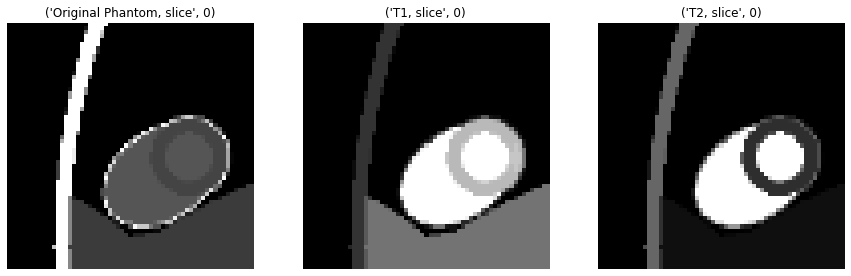

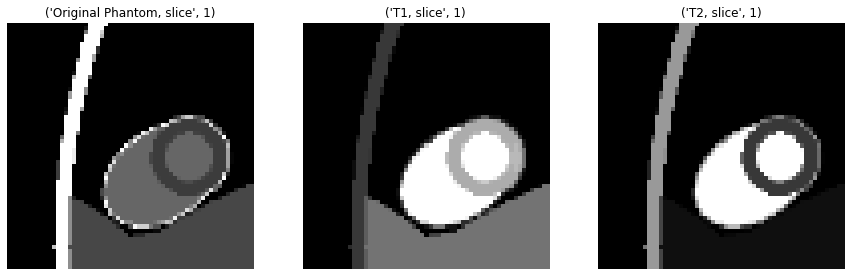

In [ ]:
# Initialize isochromat grid with 2D phantom and plot the phantom
grid = isoGrid(phantomPD, phantomT1, phantomT2, B0)

#Function for plotting the phantom maps
def plotslice(grid):
    for k in range(0,grid.getSize(2)):
        PD_title = 'Original Phantom, slice',k
        T1_title = 'T1, slice',k
        T2_title = 'T2, slice',k
        plot = plotMulti([grid.M0[:,:,k,2], grid.T1map[:,:,k], grid.T2map[:,:,k]], [PD_title, T1_title, T2_title])

plot = plotslice(grid)        

In [ ]:
nKx = grid.getSize(0)   # Number of frequency encoding steps
nKy = grid.getSize(1)   # Number of phase encoding steps
tExc_ = 1e-3
durSpoiler  = 0.5e-3    # Duration of spoiler gradient

seq   = Sequence(TR, TE, 0, nKx, nKy)
durPe = np.ceil(nKx/2)*seq.dt

range_TR = [(nKx*seq.dt+2*durPe-tExc_+durSpoiler),(nKx*seq.dt+2*durPe-tExc_+durSpoiler)*5]
range_TE = [(nKx*seq.dt/2+2*durPe-tExc_),(nKx*seq.dt/2+2*durPe-tExc_)*5]
startval_TR = (range_TR[0]+range_TR[1])/2
startval_TE = (range_TE[0]+range_TE[1])/2

#Defining float sliders for TR and TE
slider_TR = widgets.FloatSlider(value = (int)(startval_TR*1000), min = (int)(range_TR[0]*1000), max = (int)(range_TR[1]*1000), step = 1, description = 'TR (ms):',) 
slider_TE = widgets.FloatSlider(value = (int)(startval_TE*1000), min = (int)(range_TE[0]*1000), max = (int)(range_TE[1]*1000), step = 1, description = 'TE (ms):',)

#Function for displaying TR and TE sliders
def f(slider_TR, slider_TE):
    display(slider_TR, slider_TE)  
    return slider_TR, slider_TE

#Function for updating the max range of TE dependent on the value of TR
def update_TE_range(*args):
    slider_TE.max = slider_TR.value
slider_TR.observe(update_TE_range, 'value')

#Displaying the sliders
w = interactive(
    f,
    {'manual': True}, 
    slider_TR = slider_TR,
    slider_TE = slider_TE);
display(w)

interactive(children=(FloatSlider(value=35.0, description='TR (ms):', max=59.0, min=11.0, step=1.0), FloatSlid…

TR =  0.019 s
TR =  0.011 s
0.0038500334952914087
0.00012419462888036803
0.0016439643024894317


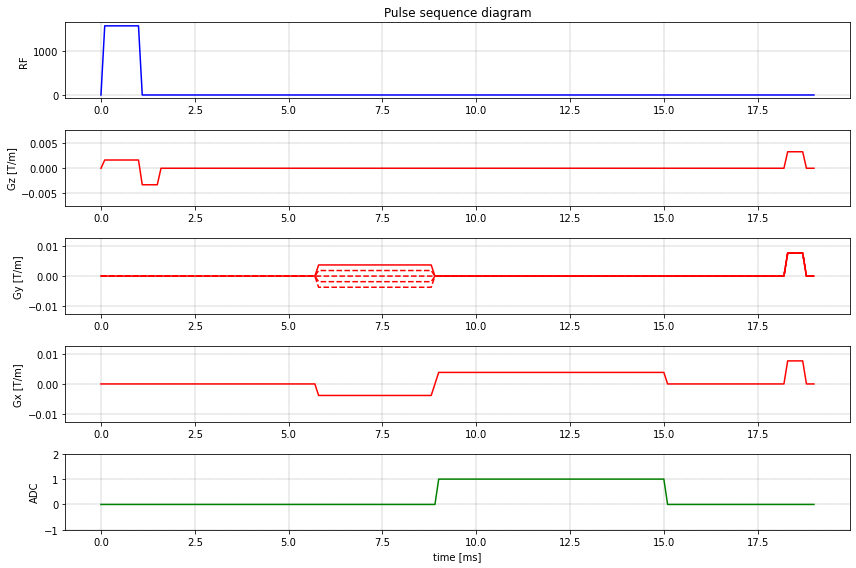

In [ ]:
# Set general parameters of the spGRE sequence
TR, TE = w.children[:2]
TR = TR.value/1000       # repetition time in [s]
TE = TE.value/1000

print('TR = ',TR,'s')
print('TR = ',TE,'s')

# Define sequence object (seq) with given parameters via Sequence class
seq = Sequence(TR, TE, 0, nKx, nKy)

# Initialize RF field object (RF) via RFpulse class
# Input:
#   seq:    Sequence
#   fa:     Flip angle in degrees
#   tExc:   duration of RF pulse
#   t0Exc:  start time of RF pulse
RF = RFpulse(seq, fa = 90, tExc = tExc_, t0Exc = 0)

# Set parameters for spGRE sequence
durPe       = np.ceil(nKx/2)*seq.dt  # Duration of phase encoding gradient
durSpoiler  = 0.5e-3                 # Duration of spoiler gradient

# Calculate field of view (FOV) and size of steps in k-Space dKx, dKy, dKz
FOV = np.multiply( np.asarray([nKx, nKy, 1]), seq.resolution )
dKx, dKy, dKz = 1 / FOV
dF = 0.7e+3 # Bandwidth [Hz]

# Set gradient amplitudes
Gx = dKx / (seq.gamma * seq.dt) # readout 
Gy = dKy / (seq.gamma * durPe)  # phase encoding 
Gz = dF / (seq.gamma * FOV[2])  # slice  

# Define gradient objects with given parameters via Gradient class
# Input:  Gradient(seq, strn, dur, t0, ax, steps)
#   seq:  Sequence object
#   strn: Gradient amplitude
#   dur:  Gradient duration         [s]
#   t0:   Start time within the TR  [s]
#   ax:   Gradient axis
#           0 : x-axis (readout)
#           1 : y-axis (phase)
#           2 : z-axis (slice)
#   steps: Number of gradient steps
Gsls    = Gradient(seq,      Gz,                      RF.tExc,     t0=0,                            ax=2,     steps=0)
Gslr    = Gradient(seq, -2 * Gz,                0.5 * RF.tExc,     t0=RF.tExc,                      ax=2,     steps=0)
Gpe     = Gradient(seq,      Gy,                      durPe,       t0=RF.tExc+TE-nKx*seq.dt/2-durPe-seq.dt,                   ax=1,     steps=nKy)
Gdeph   = Gradient(seq,     -Gx,                      durPe,       t0=RF.tExc+TE-nKx*seq.dt/2-durPe-seq.dt,                   ax=0,     steps=0)
Gra     = Gradient(seq,      Gx,                      nKx*seq.dt,  t0=RF.tExc+TE-nKx*seq.dt/2,             ax=0,     steps=0)
Gspoil  = Gradient(seq,    2*Gx,                      durSpoiler,  t0=RF.tExc+durPe+nKx*seq.dt/2+TE,  ax=[0,1], steps=0)
Gspoil  = Gradient(seq,    2*Gz,                      durSpoiler,  t0=RF.tExc+durPe+nKx*seq.dt/2+TE,  ax=2,     steps=0)

# Set ADC Timing
seq.t0ADC = Gra.t0_dts * seq.dt

# Initialize sequence with defined RF pulse, gradients and ADC
seq.calculateSequence()
seq.plotSeq()

## Static phantom (no flow)
Here, the previously defined sequence is applied for the cardiac phantom in the static case, i.e. without flow.

In [ ]:
# Set flow order to 0 (no flow)
seq.fOrder = 0

# Set up a copy of the grid to save results without flow
gridNoFlow = copy.deepcopy(grid)

# Simulate sequence on grid without flow
gridNoFlow = seq.simSeq(gridNoFlow)

Simulating excitation...

Simulating acquisition...



<ipython-input-68-130b8dbad486>:180: RuntimeWarning: divide by zero encountered in true_divide
  E1 = np.exp(-self.dt/T1)
<ipython-input-68-130b8dbad486>:181: RuntimeWarning: divide by zero encountered in true_divide
  E2 = np.exp(-self.dt/T2)



Simulating excitation...

Simulating acquisition...




Simulating excitation...

Simulating acquisition...




Simulating excitation...

Simulating acquisition...




Simulating excitation...

Simulating acquisition...




Simulating excitation...

Simulating acquisition...




Simulating excitation...

Simulating acquisition...




Simulating excitation...

Simulating acquisition...




14min 33s ± 4min 27s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Phantom with flow - 1st order
Here, the previously defined sequence is applied for the cardiac phantom in the case where flow is present. Thereby, only first order effects are considered.

In [ ]:
# Set flow order to 1 (1st order flow effects, i.e. motion with constant velocity)
seq.fOrder = 1

# Set up a copy of the grid to save results with flow
gridFlow1 = copy.deepcopy(grid)

# Simulate sequence on grid with flow
gridFlow1 = seq.simSeq(gridFlow1)

Simulating excitation...

Simulating acquisition...



<ipython-input-68-130b8dbad486>:180: RuntimeWarning: divide by zero encountered in true_divide
  E1 = np.exp(-self.dt/T1)
<ipython-input-68-130b8dbad486>:181: RuntimeWarning: divide by zero encountered in true_divide
  E2 = np.exp(-self.dt/T2)


## Phantom with flow - 2nd order
Here, the previously defined sequence is applied for the cardiac phantom in the case where flow is present. Thereby, first and second order effects are considered.

In [ ]:
# Set flow order to 2 (2nd order flow effects, i.e. motion with constant acceleration)
seq.fOrder = 2

# Set up a copy of the grid to save results with flow
gridFlow2 = copy.deepcopy(grid)

# Simulate sequence on grid with flow
gridFlow2 = seq.simSeq(gridFlow2)

Simulating excitation...

Simulating acquisition...



<ipython-input-68-130b8dbad486>:180: RuntimeWarning: divide by zero encountered in true_divide
  E1 = np.exp(-self.dt/T1)
<ipython-input-68-130b8dbad486>:181: RuntimeWarning: divide by zero encountered in true_divide
  E2 = np.exp(-self.dt/T2)


## Results
In this last section, the previously simulated and reconstructed images are displayed.

### K-space results


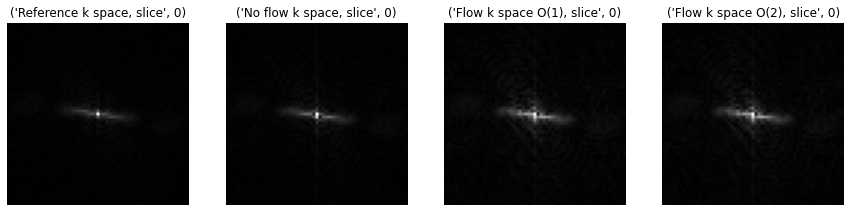

In [ ]:
def plotkspace(grid):
    for k in range(0,grid.getSize(2)):
        ref_title = 'Reference k space, slice',k
        noflow_title = 'No flow k space, slice',k
        flow1_title = 'Flow k space O(1), slice',k
        flow2_title = 'Flow k space O(2), slice',k
        titles = [ref_title, noflow_title, flow1_title, flow2_title]
        
        kSpaceOri    = np.abs(np.fft.fftshift(np.fft.fft2(grid.M0[:,:,k,2])))
        kSpaceNoFlow = np.abs(gridNoFlow[0].kSpace[:,:,k])
        kSpaceFlow1  = np.abs(gridFlow1[0].kSpace[:,:,k])
        kSpaceFlow2  = np.abs(gridFlow2[0].kSpace[:,:,k])
        plotMulti([kSpaceOri, kSpaceNoFlow, kSpaceFlow1, kSpaceFlow2], titles)

plot = plotkspace(grid)

### Simulated scans

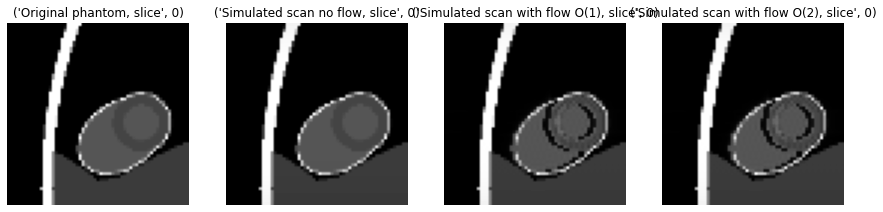

In [ ]:
def plotscans(grid, phantomPD):
    for k in range(0,grid.getSize(2)):
        scan_ref_title = 'Original phantom, slice',k
        scan_noflow_title = 'Simulated scan no flow, slice',k
        scan_flow1_title = 'Simulated scan with flow O(1), slice',k
        scan_flow2_title = 'Simulated scan with flow O(2), slice',k
        titles = [scan_ref_title, scan_noflow_title, scan_flow1_title, scan_flow2_title]
        
        phantomPD_ = phantomPD[:,:,k] 
        scanNoFlow = np.abs(np.fft.fftshift(np.fft.ifft2(gridNoFlow[0].kSpace[:,:,k])))
        scanFlow1 = np.abs(np.fft.fftshift(np.fft.ifft2(gridFlow1[0].kSpace[:,:,k])))
        scanFlow2 = np.abs(np.fft.fftshift(np.fft.ifft2(gridFlow2[0].kSpace[:,:,k])))
        plotMulti([phantomPD_, scanNoFlow, scanFlow1, scanFlow2], titles)

plot = plotscans(grid, phantomPD)

## Phantom with flow and 1st order flow compensation (FC)

TR = 19.0 ms
TE = 0.011 ms


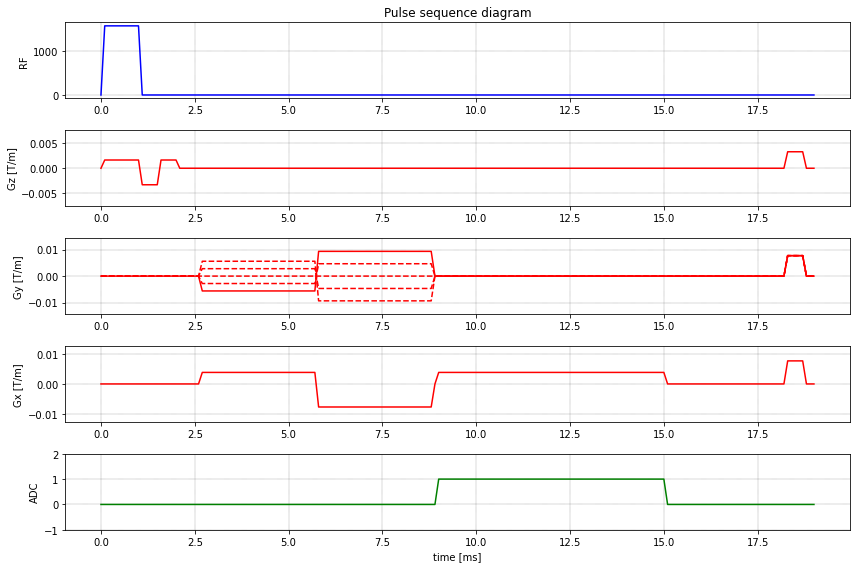

In [ ]:
# Set general parameters of the spGRE sequence
nKx = grid.getSize(0)   # Number of frequency encoding steps
nKy = grid.getSize(1)   # Number of phase encoding steps

# Define sequence object (seq) with given parameters via Sequence class
seq = Sequence(TR, TE, 0, nKx, nKy)

# Initialize RF field object (RF) via RFpulse class
# Input:
#   seq:    Sequence
#   fa:     Flip angle in degrees
#   tExc:   duration of RF pulse
#   t0Exc:  start time of RF pulse
RF = RFpulse(seq, fa = 90, tExc = 1e-3, t0Exc = 0)

# Set parameters for spGRE sequence
durPe       = np.ceil(nKx/2)*seq.dt  # Duration of phase encoding gradient
durSpoiler  = 0.5e-3                 # Duration of spoiler gradient

# Calculate field of view (FOV) and size of steps in k-Space dKx, dKy, dKz
FOV = np.multiply( np.asarray([nKx, nKy, 1]), seq.resolution )
dKx, dKy, dKz = 1 / FOV
dF = 0.7e+3 # Bandwidth [Hz]

# Set gradient amplitudes
Gx = dKx / (seq.gamma * seq.dt) # readout 
Gy = dKy / (seq.gamma * durPe)  # phase encoding 
Gz = dF / (seq.gamma * FOV[2])  # slice  

# Define gradient objects with given parameters via Gradient class
# Input:  Gradient(seq, strn, dur, t0, ax, steps)
#   seq:  Sequence object
#   strn: Gradient amplitude
#   dur:  Gradient duration         [s]
#   t0:   Start time within the TR  [s]
#   ax:   Gradient axis
#           0 : x-axis (readout)
#           1 : y-axis (phase)
#           2 : z-axis (slice)
#   steps: Number of gradient steps
Gsls    = Gradient(seq,         Gz,        RF.tExc,  t0=0,                                    ax=2,     steps=0)
Gcompz  = Gradient(seq,    -2 * Gz,  0.5 * RF.tExc,  t0=RF.tExc,                              ax=2,     steps=0)
Gslr    = Gradient(seq,         Gz,  0.5 * RF.tExc,  t0=1.5*RF.tExc,                          ax=2,     steps=0)
Gcompy  = Gradient(seq, -3 *(Gy/2),          durPe,  t0=RF.tExc+TE-nKx*seq.dt/2-2*durPe-seq.dt, ax=1,     steps=nKy)
Gpe     = Gradient(seq,  5 *(Gy/2),          durPe,  t0=RF.tExc+TE-nKx*seq.dt/2-durPe-seq.dt, ax=1,     steps=nKy)
Gcompx  = Gradient(seq,         Gx,          durPe,  t0=RF.tExc+TE-nKx*seq.dt/2-2*durPe-seq.dt, ax=0,     steps=0)
Gdeph   = Gradient(seq,    -2 * Gx,          durPe,  t0=RF.tExc+TE-nKx*seq.dt/2-durPe-seq.dt, ax=0,     steps=0)
Gra     = Gradient(seq,         Gx,     nKx*seq.dt,  t0=RF.tExc+TE-nKx*seq.dt/2 ,              ax=0,     steps=0)
Gspoil  = Gradient(seq,       2*Gx,     durSpoiler,  t0=RF.tExc+durPe+nKx*seq.dt/2+TE,        ax=[0,1], steps=0)
Gspoil  = Gradient(seq,       2*Gz,     durSpoiler,  t0=RF.tExc+durPe+nKx*seq.dt/2+TE,        ax=2,     steps=0)


# Set ADC Timing
seq.t0ADC = Gra.t0_dts * seq.dt

# Initialize sequence with defined RF pulse, gradients and ADC
seq.calculateSequence()
seq.plotSeq()

### Phantom with flow and FC - O(1)
Here, the previously defined sequence is applied for the cardiac phantom in the case where flow is present. Thereby, first order effects are considered.

In [ ]:
# Set flow order to 1 (1st order flow effects, i.e. motion with constant velocity)
seq.fOrder = 1

# Set up a copy of the grid to save results with flow
gridFlowComp1 = copy.deepcopy(grid)

# Simulate sequence on grid with flow
gridFlowComp1 = seq.simSeq(gridFlowComp1)

Simulating excitation...

Simulating acquisition...



<ipython-input-68-130b8dbad486>:180: RuntimeWarning: divide by zero encountered in true_divide
  E1 = np.exp(-self.dt/T1)
<ipython-input-68-130b8dbad486>:181: RuntimeWarning: divide by zero encountered in true_divide
  E2 = np.exp(-self.dt/T2)


## Results
In this last section, the previously simulated and reconstructed images are displayed.

### K-space results


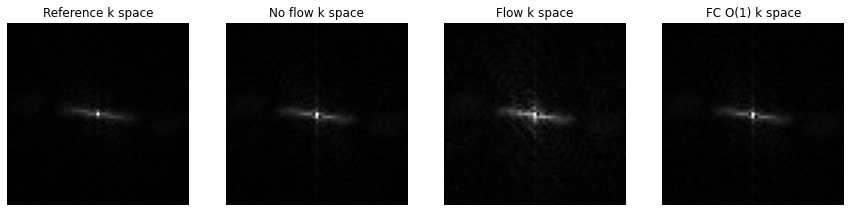

In [ ]:
def plotkspace(grid):
    for k in range(0,grid.getSize(2)):
        ref_title = 'Reference k space'#,k
        noflow_title = 'No flow k space'#,k
        flow1_title = "Flow k space"#,k
        flow1_FC_title = "FC O(1) k space"#,k
        titles = [ref_title, noflow_title, flow1_title, flow1_FC_title]
        
        # Compute reference k-space as Fourier transform of original phantom
        kSpaceOri    = np.abs(np.fft.fftshift(np.fft.fft2(grid.M0[:,:,k,2])))
        
        # Get simulated k-space from no flow and flow phantom
        kSpaceNoFlow = np.abs(gridNoFlow[0].kSpace[:,:,k])
        kSpaceFlow1   = np.abs(gridFlow1[0].kSpace[:,:,k])
        
        # Get simulated k-space with flow and with flow comp
        kSpaceFlowComp1 = np.abs(gridFlowComp1[0].kSpace[:,:,k])
        
        # Display results
        plotMulti([kSpaceOri, kSpaceNoFlow, kSpaceFlow1, kSpaceFlowComp1], titles)

plot = plotkspace(grid)

### Simulated scans

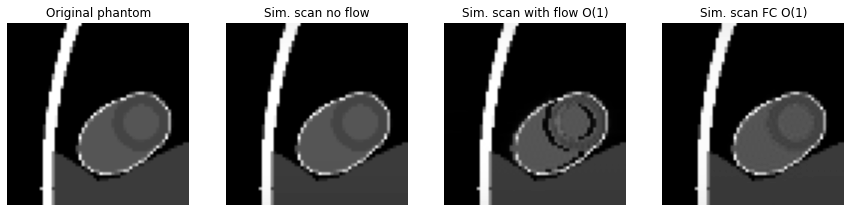

In [ ]:
def plotscans(grid, phantomPD):
    for k in range(0,grid.getSize(2)):
        scan_ref_title = 'Original phantom'#,k
        scan_noflow_title = 'Sim. scan no flow'#,k
        scan_flow1_title = 'Sim. scan with flow O(1)'#,k
        scan_flowcomp_title = 'Sim. scan FC O(1)'#,k
        titles = [scan_ref_title, scan_noflow_title, scan_flow1_title, scan_flowcomp_title]
        
        phantomPD_ = phantomPD[:,:,k] 
        
        # Reconstruct images from simulated k-Space without and with flow
        scanFlow1 = np.abs(np.fft.fftshift(np.fft.ifft2(gridFlow1[0].kSpace[:,:,k])))
        
        # Reconstruct images with flow comp
        scanNoFlow = np.abs(np.fft.fftshift(np.fft.ifft2(gridNoFlow[0].kSpace[:,:,k])))
        scanFlowComp1 = np.abs(np.fft.fftshift(np.fft.ifft2(gridFlowComp1[0].kSpace[:,:,k])))
        
        # Display reconstructed images
        plotMulti([phantomPD_, scanNoFlow, scanFlow1, scanFlowComp1], titles)

plot = plotscans(grid, phantomPD)